<a href="https://colab.research.google.com/github/Xarlie123/ir_beam/blob/main/Simulate_wf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Light pipes

### Instala dependencias

In [44]:
!pip install lightpipes
!pip install ace_tools


###Genera dataset haz laser con perturbaciones en intensidad: entrenamiento y evaluación

Generating intensity profiles: 100%|██████████| 10/10 [00:00<00:00, 1461.99it/s]


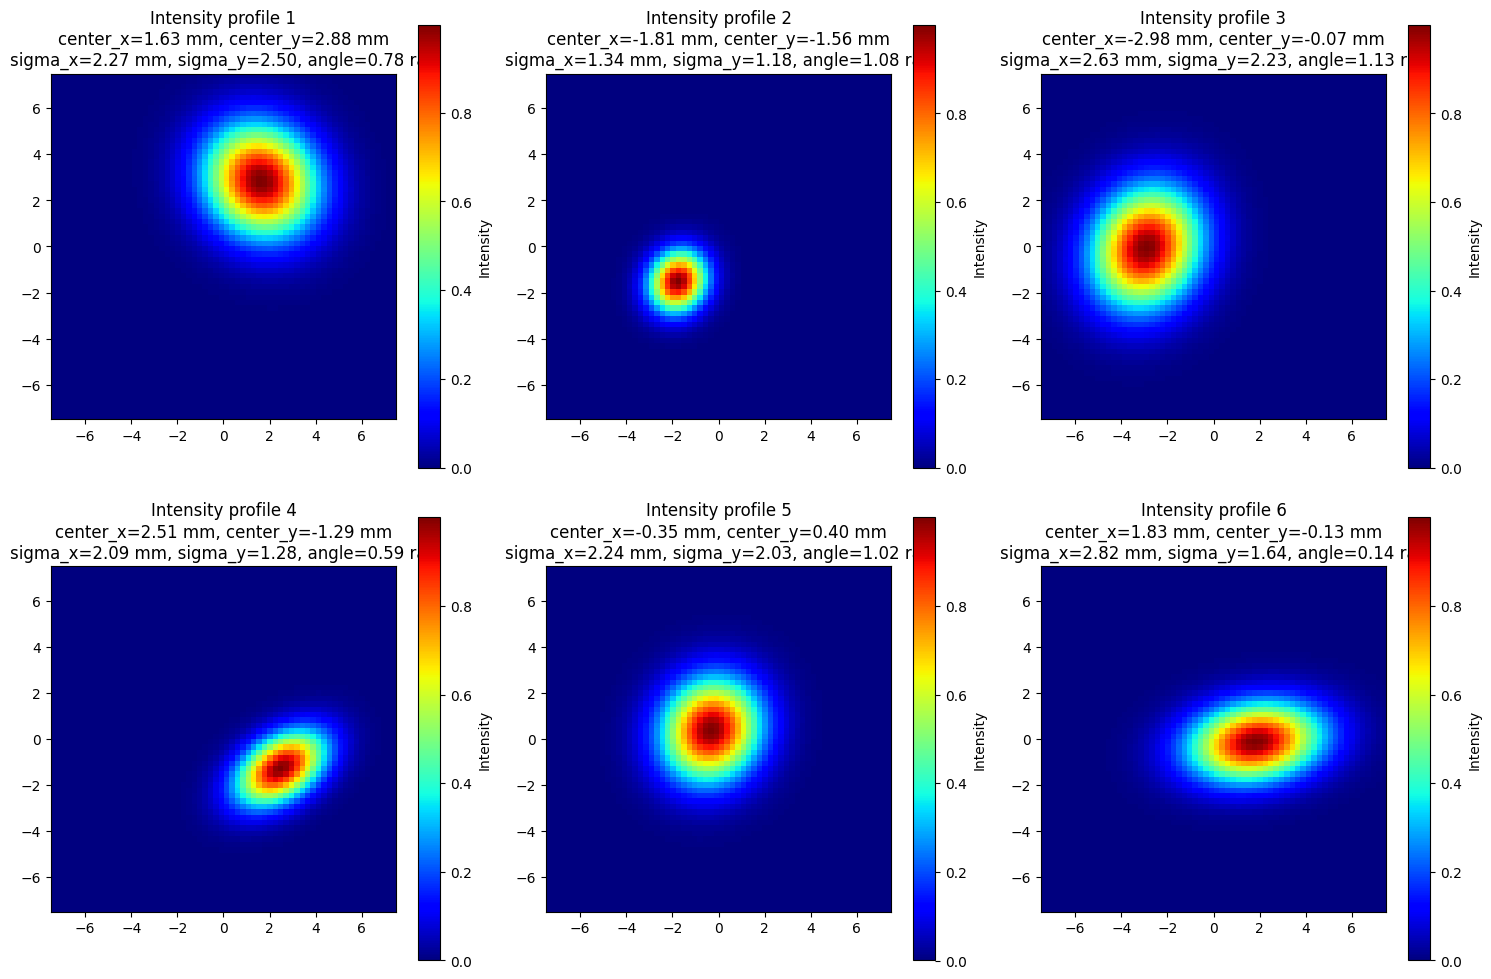

In [45]:
import numpy as np
import matplotlib.pyplot as plt
import LightPipes as lp
from tqdm import tqdm

dataset_name = 'ir_profiles_with_params'

def generate_intensity_profiles(num_images, output_file_name):
    # Define parameters for the simulation
    size = 15 * lp.mm  # Size of the grid
    wavelength = 410 * lp.nm  # Wavelength of the laser
    N = 64  # Number of grid points

    # Create an initial Gaussian beam with a larger radius
    R = 3 * lp.mm  # Radius of the beam
    F = lp.Begin(size, wavelength, N)
    F = lp.CircAperture(R, 0, 0, F)  # Centered aperture
    F = lp.GaussBeam(F, w0=0.5*lp.mm)

    # Initialize arrays to store intensity matrices and parameters
    intensity_matrices = np.zeros((num_images, N, N))
    parameters = np.zeros((num_images, 5))

    # Loop to generate and save different intensity profiles
    for i in tqdm(range(num_images), desc="Generating intensity profiles"):
        # Randomize parameters
        center_x = np.random.uniform(-3, 3) * lp.mm
        center_y = np.random.uniform(-3, 3) * lp.mm
        sigma_x = np.random.uniform(1, 3) * lp.mm
        sigma_y = np.random.uniform(1, 3) * lp.mm
        angle_ = np.random.uniform(0, np.pi/2)  # Angle of rotation

        ellipticity = np.random.uniform(75, 100)

        # Store parameters
        parameters[i] = [center_x / lp.mm, -center_y / lp.mm, sigma_x / lp.mm, sigma_y / lp.mm, angle_]

        # Apply a non-symmetric intensity modulation to the Gaussian beam
        x, y = np.meshgrid(np.linspace(-size/2, size/2, N), np.linspace(-size/2, size/2, N))

        # Rotate coordinates around the center
        x_rot = (x - center_x) * np.cos(angle_) - (y - center_y) * np.sin(angle_) + center_x
        y_rot = (x - center_x) * np.sin(angle_) + (y - center_y) * np.cos(angle_) + center_y

        #x_rot = x
        #y_rot = y

        # Gaussian intensity distribution with elliptical shape
        gaussian = np.exp(-((x_rot - center_x)**2 / sigma_x**2 + (y_rot - center_y)**2 / sigma_y**2))

        # Add perturbation to simulate ellipticity changes
        """
        if ellipticity < 100:
            perturbation_strength = (100 - ellipticity) / 100
            radius = np.sqrt((x_rot - center_x)**2 + (y_rot - center_y)**2)
            angle_grid = np.arctan2(y_rot - center_y, x_rot - center_x)

            # Introduce random phases
            phase1 = np.random.uniform(0, 2 * np.pi)
            phase2 = np.random.uniform(0, 2 * np.pi)
            phase3 = np.random.uniform(0, 2 * np.pi)

            perturbation = (perturbation_strength *
                            (1 * np.sin(1 * angle_grid + phase1) +
                             0.3 * np.sin(2 * angle_grid + phase2) +
                             0.2 * np.sin(3 * angle_grid + phase3)) *
                            np.exp(-radius / (2 * sigma)))
            gaussian += perturbation
          """

        # Clip values to ensure they are within the valid range
        gaussian = np.clip(gaussian, 0, 1)

        F_mod = lp.SubIntensity(gaussian, F)

        # Convert the result to intensity
        I = lp.Intensity(0, F_mod)

        # Store the intensity matrix
        intensity_matrices[i] = I

    # Save the intensity matrices and parameters to a .npz file
    np.savez(output_file_name+'.npz', intensity_matrices=intensity_matrices, parameters=parameters)

    # Plot a few intensity profiles to visualize
    plt.figure(figsize=(15, 10))

    for i in range(min(6, num_images)):
        params = parameters[i]
        plt.subplot(2, 3, i+1)
        plt.imshow(intensity_matrices[i], extent=[-size/2/lp.mm, size/2/lp.mm, -size/2/lp.mm, size/2/lp.mm], cmap='jet')
        plt.title(f'Intensity profile {i+1}\n'
                  f'center_x={params[0]:.2f} mm, center_y={params[1]:.2f} mm\n'
                  f'sigma_x={params[2]:.2f} mm, sigma_y={params[3]:.2f}, angle={params[4]:.2f} rad')
        plt.colorbar(label='Intensity')

    plt.tight_layout()
    plt.show()

# Example usage:
generate_intensity_profiles(10, dataset_name)



A partir del dataset existente, crea uno nuevo con ruido. El ruido puede ser "head", "tail", "random".

Applying FWHT noise (head): 100%|██████████| 10/10 [00:26<00:00,  2.67s/it]


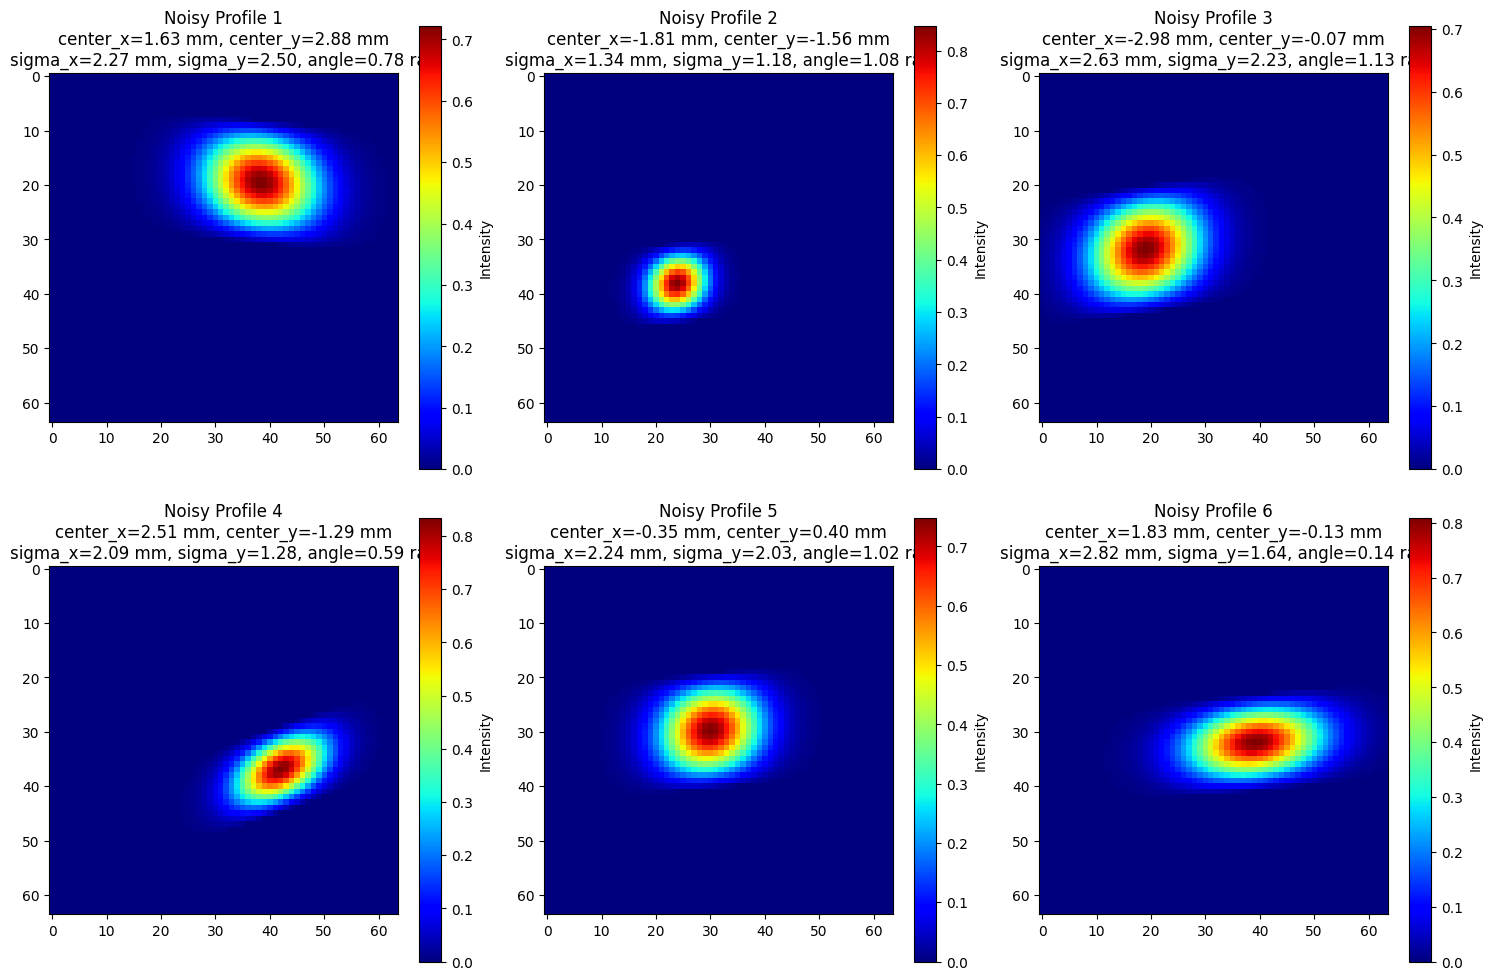

In [46]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from sympy import fwht, ifwht

def apply_fwht_noise(array, noise_level=10, mode="random", random_seed=10):
    """
    Applies Fast Walsh Hadamard Transform (FWHT) noise based on a reference strategy.

    Parameters:
        - array: Input dataset (N, H, W) where N = number of images.
        - noise_level: Percentage of elements to set to zero.
        - mode: "head", "tail", or "random" to determine noise distribution.
        - random_seed: Seed for reproducibility in random mode.

    Returns:
        - Transformed array with FWHT noise applied.
    """
    np.random.seed(random_seed)
    N, H, W = array.shape
    new_array = np.zeros_like(array)
    num_zeros = int(noise_level / 100 * (H * W))  # Number of elements to be set to zero

    for i in tqdm(range(N), desc=f"Applying FWHT noise ({mode})"):
        img_1d = array[i].flatten(order='C')
        img_fwht = fwht(img_1d)  # Apply FWHT

        mask = np.ones_like(img_fwht)  # Initialize a mask of ones

        if mode == "head":
            indices = np.arange(num_zeros)  # First elements affected
        elif mode == "tail":
            indices = np.arange(len(img_fwht) - num_zeros, len(img_fwht))  # Last elements affected
        elif mode == "random":
            indices = np.random.choice(len(img_fwht), size=num_zeros, replace=False)  # Random selection
        else:
            raise ValueError("Invalid mode. Choose 'head', 'tail', or 'random'.")

        mask[indices] = 0  # Apply mask
        masked_array = img_fwht * mask  # Apply noise by masking FWHT coefficients

        img_ifwht = ifwht(masked_array)  # Inverse FWHT
        img_new = np.reshape(img_ifwht, (H, W))  # Reshape back to 2D
        new_array[i] = np.clip(img_new, 0, 1)  # Ensure valid intensity range

    return new_array

def add_fwht_noise_to_npz(input_file, output_file, noise_level=10, mode="random"):
    """
    Loads an existing dataset from a .npz file, applies FWHT noise, and saves a new dataset.

    Parameters:
        - input_file: Path to the input .npz file.
        - output_file: Path to save the modified dataset.
        - noise_level: Percentage of the spectrum to be affected by noise.
        - mode: "head", "tail", or "random" for noise application strategy.
    """
    # Load existing dataset
    data = np.load(input_file + '.npz')
    intensity_matrices = data['intensity_matrices']
    parameters = data['parameters']

    # Apply FWHT noise
    noisy_intensity_matrices = apply_fwht_noise(intensity_matrices, noise_level=noise_level, mode=mode)

    # Save the modified dataset
    np.savez(output_file + '.npz', intensity_matrices=noisy_intensity_matrices, parameters=parameters)

    # Visualization of noisy images
    plt.figure(figsize=(15, 10))
    for i in range(min(6, len(noisy_intensity_matrices))):
        params = parameters[i]
        plt.subplot(2, 3, i + 1)
        plt.imshow(noisy_intensity_matrices[i], cmap='jet')
        plt.title(f'Noisy Profile {i+1}\n'
                  f'center_x={params[0]:.2f} mm, center_y={params[1]:.2f} mm\n'
                  f'sigma_x={params[2]:.2f} mm, sigma_y={params[3]:.2f}, angle={params[4]:.2f} rad')
        plt.colorbar(label='Intensity')

    plt.tight_layout()
    plt.show()

dataset_name_noise = 'intensity_matrices_fwht_noise_head'
# Example usage: Apply FWHT noise to existing dataset
add_fwht_noise_to_npz(dataset_name, 'intensity_matrices_fwht_noise_head', noise_level=10, mode="head")
#add_fwht_noise_to_npz(dataset_name, 'intensity_matrices_fwht_noise_tail', noise_level=10, mode="tail")
#add_fwht_noise_to_npz(dataset_name, 'intensity_matrices_fwht_noise_random', noise_level=10, mode="random")


### Importa dataset en .npz y crea dataframe con imágenes + 5 parámetros (centro_x, centro_y, sigma_x, sigma_y y ángulo)

In [50]:
import numpy as np
import pandas as pd

def load_npz_to_dataframe(dataset_name, dataset_name_noise):
    """
    Loads two .npz datasets (one original and one with noise) and converts them into Pandas DataFrames.

    Parameters:
        - dataset_name: Name of the original .npz file (without extension).
        - dataset_name_noise: Name of the noisy .npz file (without extension).

    Returns:
        - df_original: DataFrame containing original data.
        - df_noisy: DataFrame containing noisy data.
    """
    # Load datasets
    data_original = np.load(dataset_name + '.npz')
    data_noisy = np.load(dataset_name_noise + '.npz')

    # Extract data
    intensity_matrices_original = data_original['intensity_matrices']
    parameters_original = data_original['parameters']

    intensity_matrices_noisy = data_noisy['intensity_matrices']
    parameters_noisy = data_noisy['parameters']

    # Flatten intensity matrices for easier handling
    num_samples, height, width = intensity_matrices_original.shape
    flattened_original = intensity_matrices_original.reshape(num_samples, -1)
    flattened_noisy = intensity_matrices_noisy.reshape(num_samples, -1)

    # Convert to DataFrames
    df_original = pd.DataFrame(flattened_original)
    df_original.insert(0, "center_x", parameters_original[:, 0])
    df_original.insert(1, "center_y", parameters_original[:, 1])
    df_original.insert(2, "sigma_x", parameters_original[:, 2])
    df_original.insert(3, "sigma_y", parameters_original[:, 3])
    df_original.insert(4, "angle", parameters_original[:, 4])

    df_noisy = pd.DataFrame(flattened_noisy)
    df_noisy.insert(0, "center_x", parameters_noisy[:, 0])
    df_noisy.insert(1, "center_y", parameters_noisy[:, 1])
    df_noisy.insert(2, "sigma_x", parameters_noisy[:, 2])
    df_noisy.insert(3, "sigma_y", parameters_noisy[:, 3])
    df_noisy.insert(4, "angle", parameters_noisy[:, 4])

    return df_original, df_noisy

# Example usage
dataset_name = "intensity_matrices_with_params"
dataset_name_noise = "intensity_matrices_fwht_noise"

df_original, df_noisy = load_npz_to_dataframe(dataset_name, dataset_name_noise)

# Display the DataFrames
from IPython.display import display
display(df_original)  # Muestra el DataFrame original
display(df_noisy)     # Muestra el DataFrame con ruido



,center_x,center_y,sigma_x,sigma_y,angle,0,1,2,3,4,...,4086,4087,4088,4089,4090,4091,4092,4093,4094,4095
0,1.278068,-1.359696,1.688764,1.189550,0.484830,2.020546e-46,2.192208e-45,2.265798e-44,2.230936e-43,2.092566e-42,...,2.557819e-17,7.077130e-18,1.865395e-18,4.683935e-19,1.120411e-19,2.553114e-20,5.542291e-21,1.146133e-21,2.257911e-22,4.237456e-23
1,1.962190,-0.655427,1.475270,1.221304,0.865700,3.683746e-46,7.346865e-45,1.371722e-43,2.397626e-42,3.923271e-41,...,6.838240e-17,1.839680e-17,4.633313e-18,1.092427e-18,2.411265e-19,4.982519e-20,9.638388e-21,1.745466e-21,2.959170e-22,4.696560e-23
2,-1.249473,0.663764,1.179724,1.983672,0.241405,3.657572e-14,1.941954e-13,9.532617e-13,4.326258e-12,1.815264e-11,...,6.444347e-17,1.068310e-17,1.637354e-18,2.320144e-19,3.039586e-20,3.681638e-21,4.122824e-22,4.268503e-23,4.085860e-24,3.615918e-25
3,2.402490,1.315354,2.519885,1.897133,1.191782,6.004911e-17,2.292170e-16,8.494097e-16,3.055751e-15,1.067208e-14,...,1.591954e-08,9.127696e-09,5.080684e-09,2.745449e-09,1.440240e-09,7.334776e-10,3.626344e-10,1.740530e-10,8.110062e-11,3.668574e-11
4,0.239902,-2.802822,1.938676,2.490198,0.495405,1.599719e-12,3.109231e-12,5.879325e-12,1.081601e-11,1.935852e-11,...,2.434924e-04,1.467541e-04,8.605190e-05,4.909031e-05,2.724559e-05,1.471167e-05,7.728461e-06,3.949928e-06,1.964041e-06,9.501172e-07
5,0.110346,0.269693,1.234733,2.003196,0.815512,1.184432e-12,2.832386e-12,6.443374e-12,1.394418e-11,2.870721e-11,...,5.462039e-11,3.757542e-11,2.459073e-11,1.530938e-11,9.066975e-12,5.108411e-12,2.737965e-12,1.396010e-12,6.771233e-13,3.124393e-13
6,-1.281346,-2.902700,2.399667,2.238646,0.765908,2.262335e-13,4.141165e-13,7.422069e-13,1.302459e-12,2.237897e-12,...,2.388504e-06,1.275744e-06,6.671717e-07,3.416241e-07,1.712758e-07,8.407763e-08,4.041118e-08,1.901775e-08,8.763018e-09,3.953529e-09
7,-0.000405,1.604856,2.606362,2.919908,1.471164,1.057240e-05,1.585043e-05,2.344868e-05,3.422993e-05,4.930644e-05,...,2.346944e-07,1.749445e-07,1.286791e-07,9.339552e-08,6.688890e-08,4.727071e-08,3.296403e-08,2.268290e-08,1.540163e-08,1.031918e-08
8,-1.141587,1.220197,2.847473,2.884981,1.120044,6.624974e-05,9.448723e-05,1.329280e-04,1.844649e-04,2.525023e-04,...,6.217738e-07,4.271930e-07,2.895144e-07,1.935398e-07,1.276217e-07,8.301054e-08,5.325937e-08,3.370645e-08,2.104186e-08,1.295715e-08
9,0.939636,0.688107,2.500327,1.606355,1.518671,1.598903e-16,7.696663e-16,3.545935e-15,1.563533e-14,6.598293e-14,...,4.712714e-09,1.950798e-09,7.728617e-10,2.930483e-10,1.063468e-10,3.693670e-11,1.227834e-11,3.906332e-12,1.189451e-12,3.466349e-13


,center_x,center_y,sigma_x,sigma_y,angle,0,1,2,3,4,...,4086,4087,4088,4089,4090,4091,4092,4093,4094,4095
0,-2.839785,1.952158,1.339639,2.885974,0.274596,1.378872e-07,4.600776e-07,1.441123e-06,4.237736e-06,1.169848e-05,...,0.000000e+00,1.431443e-17,0.000000e+00,1.122276e-17,0.000000e+00,2.460546e-17,1.941632e-17,7.843525e-18,1.390775e-17,1.296320e-17
1,1.918664,2.254749,2.214827,2.109504,1.030767,2.891123e-11,7.130570e-11,1.718480e-10,4.046941e-10,9.312614e-10,...,4.641733e-11,3.286248e-11,2.273436e-11,1.536836e-11,1.015159e-11,6.552438e-12,4.132725e-12,2.547006e-12,1.533859e-12,9.026446e-13
2,-2.029759,1.414552,1.143346,1.757643,1.112478,6.883271e-16,4.988950e-15,3.221942e-14,1.902757e-13,1.030247e-12,...,0.000000e+00,0.000000e+00,1.986908e-17,9.916175e-19,1.524591e-18,0.000000e+00,1.970792e-17,1.164929e-17,1.204351e-17,1.150290e-17
3,1.537323,-1.099211,1.345248,2.617241,0.734903,0.000000e+00,0.000000e+00,0.000000e+00,6.218916e-18,0.000000e+00,...,7.959028e-07,2.823167e-07,9.405982e-08,2.943492e-08,8.651923e-09,2.388656e-09,6.194204e-10,1.508720e-10,3.451618e-11,7.416984e-12
4,-1.172050,0.813511,1.858893,1.128447,1.170142,0.000000e+00,0.000000e+00,0.000000e+00,7.121853e-18,6.627186e-18,...,9.252141e-18,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.972334e-17,1.211571e-17,1.056635e-17,1.498959e-17,0.000000e+00
5,0.998450,-2.601794,2.070203,2.850318,1.061004,1.683688e-13,4.271912e-13,1.055462e-12,2.539845e-12,5.952296e-12,...,6.198396e-04,3.768839e-04,2.231755e-04,1.287053e-04,7.228646e-05,3.953924e-05,2.106253e-05,1.092707e-05,5.520868e-06,2.716577e-06
6,-2.747139,-1.548279,2.219552,1.503745,1.534294,0.000000e+00,6.505213e-18,0.000000e+00,0.000000e+00,0.000000e+00,...,2.550807e-13,1.152102e-13,5.083876e-14,2.196329e-14,9.242784e-15,3.814155e-15,1.556786e-15,6.070083e-16,2.712905e-16,1.102588e-16
7,2.994559,1.370461,1.172451,1.713468,0.680489,7.758121e-19,1.230359e-17,1.268260e-17,0.000000e+00,0.000000e+00,...,3.957772e-14,1.674312e-14,6.535679e-15,2.351147e-15,7.935276e-16,2.168845e-16,6.638705e-17,4.087696e-17,2.715164e-17,0.000000e+00
8,-2.026295,2.031953,1.100427,2.803245,0.481793,4.000532e-13,3.285345e-12,2.456968e-11,1.673229e-10,1.037644e-09,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.420200e-17,0.000000e+00,0.000000e+00
9,0.963455,1.418568,2.566206,2.408979,1.408621,3.223836e-08,5.894120e-08,1.059224e-07,1.871026e-07,3.248587e-07,...,5.946759e-08,4.291048e-08,3.043472e-08,2.121769e-08,1.453951e-08,9.793195e-09,6.483685e-09,4.219319e-09,2.698893e-09,1.696883e-09


## Denoising de la imagen después de quitar algunos coeficientes

### Entrenamiento CNN denoising

Epoch [1/20], Loss: 0.3109
Epoch [2/20], Loss: 0.3064
Epoch [3/20], Loss: 0.3030
Epoch [4/20], Loss: 0.3007
Epoch [5/20], Loss: 0.2989
Epoch [6/20], Loss: 0.2973
Epoch [7/20], Loss: 0.2958
Epoch [8/20], Loss: 0.2945
Epoch [9/20], Loss: 0.2932
Epoch [10/20], Loss: 0.2917
Epoch [11/20], Loss: 0.2901
Epoch [12/20], Loss: 0.2882
Epoch [13/20], Loss: 0.2861
Epoch [14/20], Loss: 0.2837
Epoch [15/20], Loss: 0.2809
Epoch [16/20], Loss: 0.2778
Epoch [17/20], Loss: 0.2743
Epoch [18/20], Loss: 0.2705
Epoch [19/20], Loss: 0.2663
Epoch [20/20], Loss: 0.2616
Entrenamiento completado.


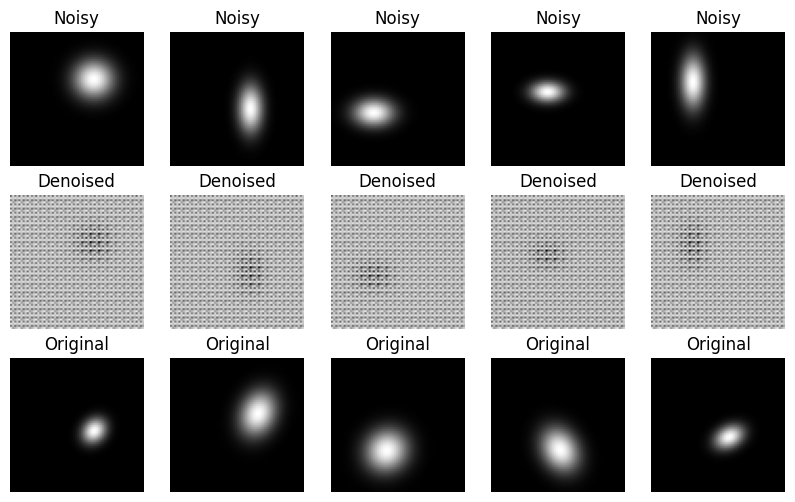

In [51]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

# 1️⃣ Preprocesar DataFrames (Eliminar las primeras 5 columnas con parámetros)
df_noisy_images = df_noisy.iloc[:, 5:].values  # Eliminar parámetros
df_original_images = df_original.iloc[:, 5:].values  # Eliminar parámetros

# Normalizar los datos al rango [0,1]
df_noisy_images = df_noisy_images.astype("float32") / 1.0
df_original_images = df_original_images.astype("float32") / 1.0

# 2️⃣ Definir el Dataset en PyTorch
class ImageDataset(Dataset):
    def __init__(self, noisy_images, clean_images, img_size=64):
        self.noisy_images = torch.tensor(noisy_images, dtype=torch.float32).view(-1, 1, img_size, img_size)
        self.clean_images = torch.tensor(clean_images, dtype=torch.float32).view(-1, 1, img_size, img_size)

    def __len__(self):
        return len(self.noisy_images)

    def __getitem__(self, idx):
        return self.noisy_images[idx], self.clean_images[idx]

# Definir el tamaño de imagen
img_size = int(np.sqrt(df_original_images.shape[1]))  # Extraer tamaño de imagen cuadrada

# Crear dataset y DataLoader
dataset = ImageDataset(df_noisy_images, df_original_images, img_size)
train_loader = DataLoader(dataset, batch_size=32, shuffle=True)

# 3️⃣ Definir el Autoencoder en PyTorch
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),  # (64x64) -> (64x64)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # (64x64) -> (32x32)
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)  # (32x32) -> (16x16)
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2),  # (16x16) -> (32x32)
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, kernel_size=2, stride=2),  # (32x32) -> (64x64)
            nn.Sigmoid()  # Salida en el rango [0,1]
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# 4️⃣ Instanciar el modelo y definir función de pérdida y optimizador
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = Autoencoder().to(device)
criterion = nn.MSELoss()  # Función de pérdida (mínimos cuadrados)
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 5️⃣ Entrenar el Autoencoder
num_epochs = 20

for epoch in range(num_epochs):
    running_loss = 0.0
    for noisy_imgs, clean_imgs in train_loader:
        noisy_imgs, clean_imgs = noisy_imgs.to(device), clean_imgs.to(device)

        # Forward
        outputs = model(noisy_imgs)
        loss = criterion(outputs, clean_imgs)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}")

print("Entrenamiento completado.")

# 6️⃣ Evaluar el modelo y visualizar los resultados
model.eval()
with torch.no_grad():
    sample_noisy, sample_clean = next(iter(train_loader))
    sample_noisy = sample_noisy.to(device)
    reconstructed = model(sample_noisy).cpu()

# 7️⃣ Mostrar imágenes originales, ruidosas y reconstruidas
n = 5  # Número de imágenes a visualizar
plt.figure(figsize=(10, 6))

for i in range(n):
    # Imagen ruidosa
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(sample_noisy[i].cpu().numpy().squeeze(), cmap="gray")
    plt.title("Noisy")
    plt.axis("off")

    # Imagen reconstruida (denoised)
    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(reconstructed[i].numpy().squeeze(), cmap="gray")
    plt.title("Denoised")
    plt.axis("off")

    # Imagen original (ground truth)
    ax = plt.subplot(3, n, i + 1 + 2 * n)
    plt.imshow(sample_clean[i].cpu().numpy().squeeze(), cmap="gray")
    plt.title("Original")
    plt.axis("off")

plt.show()


## Inferencia parámetros sin ruido

### Entrenamiento CNN

Epoch 1/80
100/100 [==============================] - 3s 8ms/step - loss: 0.1183 - mae: 0.2820 - val_loss: 0.1021 - val_mae: 0.2695
Epoch 2/80
100/100 [==============================] - 1s 6ms/step - loss: 0.0915 - mae: 0.2523 - val_loss: 0.0817 - val_mae: 0.2404
Epoch 3/80
100/100 [==============================] - 1s 6ms/step - loss: 0.0784 - mae: 0.2303 - val_loss: 0.0555 - val_mae: 0.1955
Epoch 4/80
100/100 [==============================] - 1s 6ms/step - loss: 0.0753 - mae: 0.2232 - val_loss: 0.0520 - val_mae: 0.1849
Epoch 5/80
100/100 [==============================] - 1s 6ms/step - loss: 0.0649 - mae: 0.2047 - val_loss: 0.0554 - val_mae: 0.1897
Epoch 6/80
100/100 [==============================] - 1s 6ms/step - loss: 0.0591 - mae: 0.1968 - val_loss: 0.0491 - val_mae: 0.1720
Epoch 7/80
100/100 [==============================] - 1s 6ms/step - loss: 0.0560 - mae: 0.1898 - val_loss: 0.0521 - val_mae: 0.1813
Epoch 8/80
100/100 [==============================] - 1s 6ms/step - loss: 0.

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


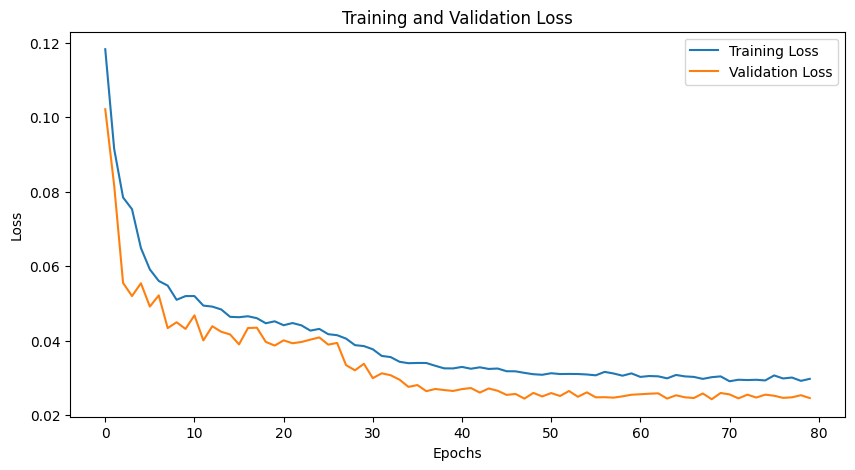

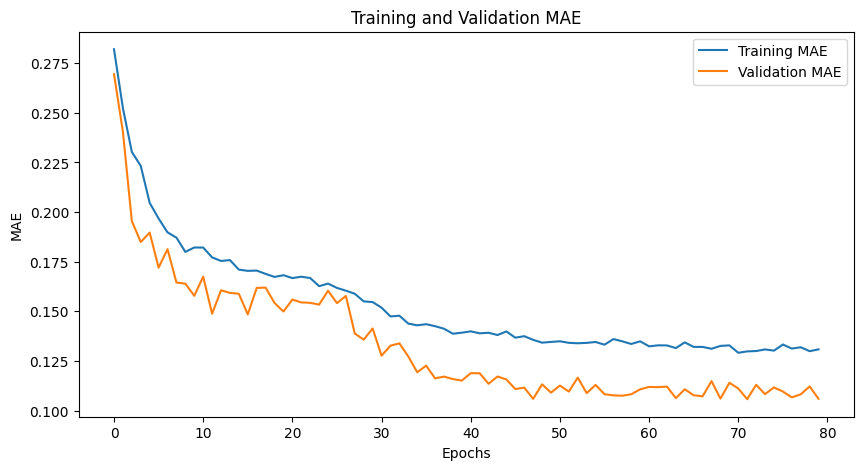

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# Cargar el archivo .npz
data = np.load('intensity_matrices_with_params.npz')

# Extraer las matrices de intensidad y los parámetros
intensity_matrices = data['intensity_matrices']
parameters = data['parameters']

# Normalizar las imágenes
intensity_matrices = intensity_matrices / np.max(intensity_matrices)

# Normalizar los parámetros
parameters[:, 0] = (parameters[:, 0] + 3) / 6  # center_x normalizado entre 0 y 1
parameters[:, 1] = (parameters[:, 1] + 3) / 6  # center_y normalizado entre 0 y 1
parameters[:, 2] = (parameters[:, 2] - 1) / 2  # sigma_x normalizado entre 0 y 1
parameters[:, 3] = (parameters[:, 3] - 1) / 2  # sigma_y normalizado entre 0 y 1
parameters[:, 4] = (parameters[:, 4]) / (np.pi/2)  # angle normalizado entre 0 y 1

# Dividir el conjunto de datos en entrenamiento y validación
X_train, X_val, y_train, y_val = train_test_split(intensity_matrices, parameters, test_size=0.2, random_state=42)

# Expandir las dimensiones de las imágenes para que sean compatibles con la entrada de la CNN
X_train = np.expand_dims(X_train, axis=-1)
X_val = np.expand_dims(X_val, axis=-1)

# Definir el modelo de la CNN más complejo
model = Sequential([
    Conv2D(64, (3, 3), activation='relu', input_shape=(100, 100, 1)),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(256, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(512, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(1024, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(1024, activation='relu'),
    Dropout(0.5),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(5)  # 5 parámetros a predecir
])

# Compilar el modelo
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Entrenar el modelo
history = model.fit(X_train, y_train, epochs=80, validation_data=(X_val, y_val), batch_size=8)

# Guardar el modelo entrenado
model.save('cnn_model.h5')

# Graficar la pérdida de entrenamiento y validación
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Graficar el MAE de entrenamiento y validación
plt.figure(figsize=(10, 5))
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Training and Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.show()


### 1era Evaluacion del modelo con dataset de evaluación



7/7 [==============================] - 0s 3ms/step


<ipython-input-84-1426ad0f7db8>:87: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


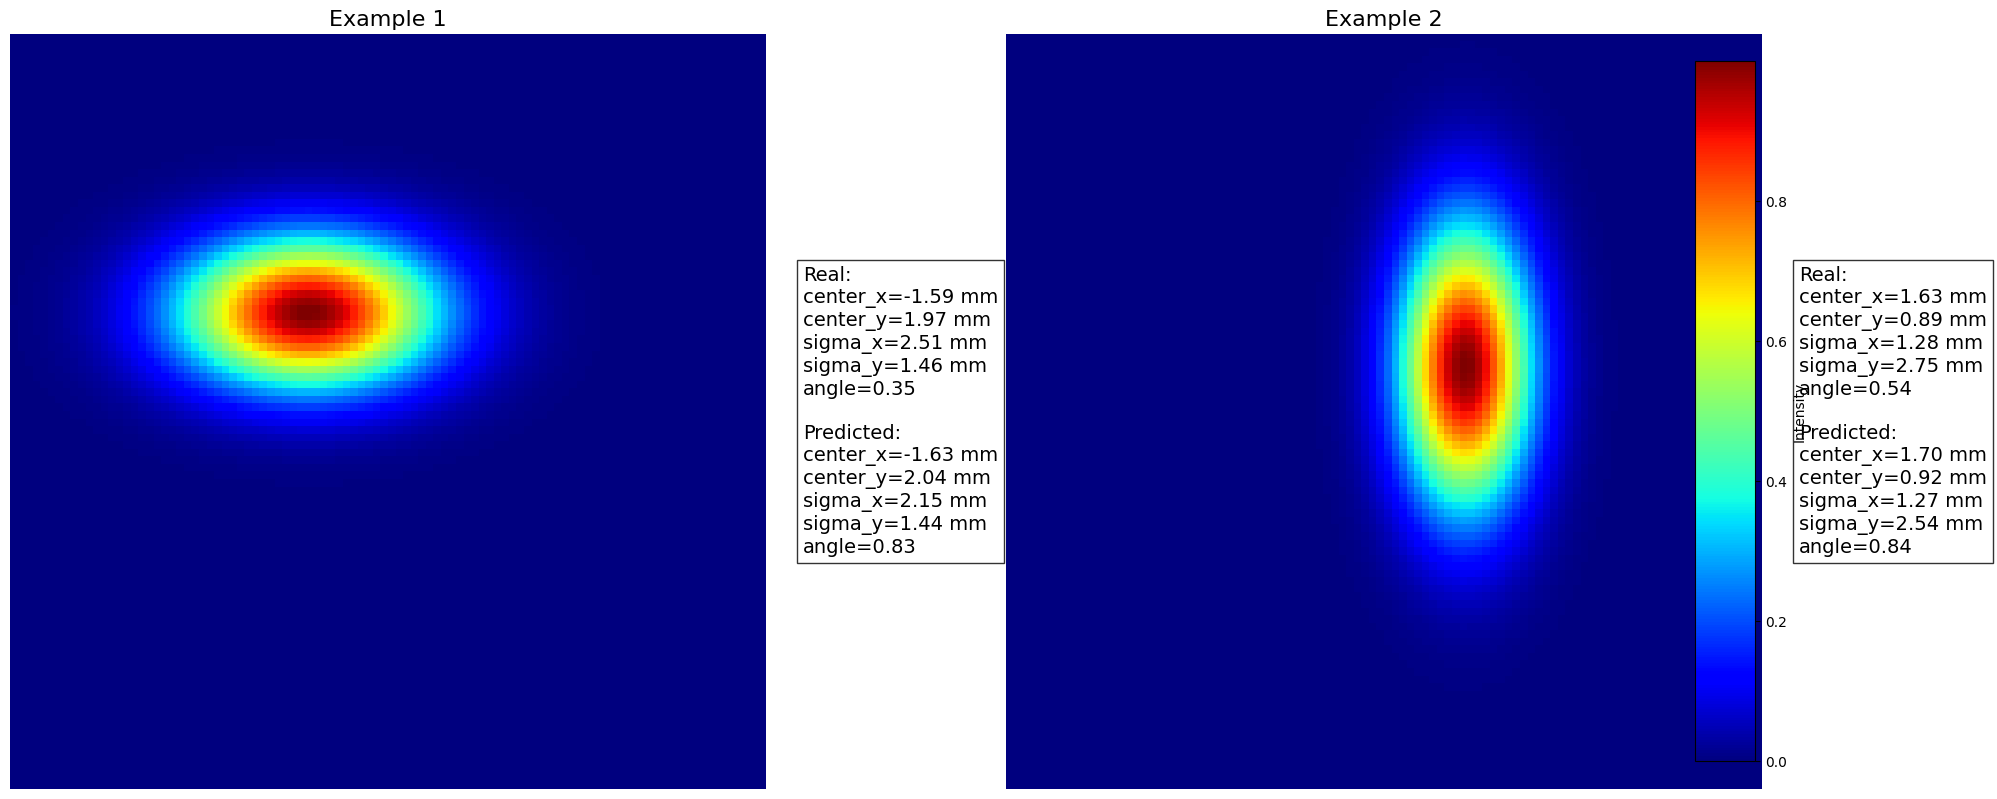

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split

# Cargar el archivo .npz
data = np.load('eval_intensity_matrices_with_params.npz')

# Extraer las matrices de intensidad y los parámetros
intensity_matrices = data['intensity_matrices']
parameters = data['parameters']

# Normalizar las imágenes
intensity_matrices = intensity_matrices / np.max(intensity_matrices)

# Normalizar los parámetros
parameters[:, 0] = (parameters[:, 0] + 3) / 6  # center_x normalizado entre 0 y 1
parameters[:, 1] = (parameters[:, 1] + 3) / 6  # center_y normalizado entre 0 y 1
parameters[:, 2] = (parameters[:, 2] - 1) / 2  # sigma_x normalizado entre 0 y 1
parameters[:, 3] = (parameters[:, 3] - 1) / 2  # sigma_y normalizado entre 0 y 1
parameters[:, 4] = (parameters[:, 4]) / (np.pi/2) # angle normalizado entre 0 y 1

# Dividir el conjunto de datos en entrenamiento y validación
_, X_val, _, y_val = train_test_split(intensity_matrices, parameters, test_size=0.2, random_state=42)

# Expandir las dimensiones de las imágenes para que sean compatibles con la entrada de la CNN
X_val = np.expand_dims(X_val, axis=-1)

# Cargar el modelo entrenado
model = tf.keras.models.load_model('cnn_model.h5')

# Evaluar el modelo en el conjunto de validación
predictions = model.predict(X_val)

# Desnormalizar las predicciones y los valores reales
predictions[:, 0] = predictions[:, 0] * 6 - 3  # Desnormalizar center_x
predictions[:, 1] = predictions[:, 1] * 6 - 3  # Desnormalizar center_y
predictions[:, 2] = predictions[:, 2] * 2 + 1  # Desnormalizar sigma_x
predictions[:, 3] = predictions[:, 3] * 2 + 1  # Desnormalizar sigma_y
predictions[:, 4] = predictions[:, 4] * (np.pi/2)  # Desnormalizar angle

y_val[:, 0] = y_val[:, 0] * 6 - 3  # Desnormalizar center_x
y_val[:, 1] = y_val[:, 1] * 6 - 3  # Desnormalizar center_y
y_val[:, 2] = y_val[:, 2] * 2 + 1  # Desnormalizar sigma_x
y_val[:, 3] = y_val[:, 3] * 2 + 1  # Desnormalizar sigma_y
y_val[:, 4] = y_val[:, 4] * (np.pi/2)  # Desnormalizar angle

# Seleccionar algunos ejemplos para mostrar
num_examples = 2
indices = np.random.choice(np.arange(X_val.shape[0]), num_examples, replace=False)

# Mostrar las imágenes, los valores reales y los valores predichos
fig, axes = plt.subplots(1, num_examples, figsize=(20, 10))

for i, idx in enumerate(indices):
    intensity_matrix = X_val[idx].squeeze()
    real_params = y_val[idx]
    predicted_params = predictions[idx]

    ax = axes[i]
    im = ax.imshow(intensity_matrix, cmap='jet', extent=[-size/2/lp.mm, size/2/lp.mm, -size/2/lp.mm, size/2/lp.mm])
    ax.set_title(f'Example {i + 1}', fontsize=16)
    ax.axis('off')

    textstr = (f'Real:\n'
               f'center_x={real_params[0]:.2f} mm\n'
               f'center_y={real_params[1]:.2f} mm\n'
               f'sigma_x={real_params[2]:.2f} mm\n'
               f'sigma_y={real_params[3]:.2f} mm\n'
               f'angle={real_params[4]:.2f}\n\n'
               f'Predicted:\n'
               f'center_x={predicted_params[0]:.2f} mm\n'
               f'center_y={predicted_params[1]:.2f} mm\n'
               f'sigma_x={predicted_params[2]:.2f} mm\n'
               f'sigma_y={predicted_params[3]:.2f} mm\n'
               f'angle={predicted_params[4]:.2f}')

    # Poner el texto a la derecha del gráfico
    ax.text(1.05, 0.5, textstr, transform=ax.transAxes, fontsize=14,
            verticalalignment='center', bbox=dict(facecolor='white', alpha=0.8))

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.03, 0.7])
fig.colorbar(im, cax=cbar_ax, label='Intensity')

plt.tight_layout()
plt.show()


### Resultados: representación prediccion vs referencia  +  histograma error

7/7 [==============================] - 0s 3ms/step
MAE for center_x: 0.29
MAE for center_y: 0.32
MAE for sigma_x: 0.15
MAE for sigma_y: 0.13
MAE for angle: 0.43


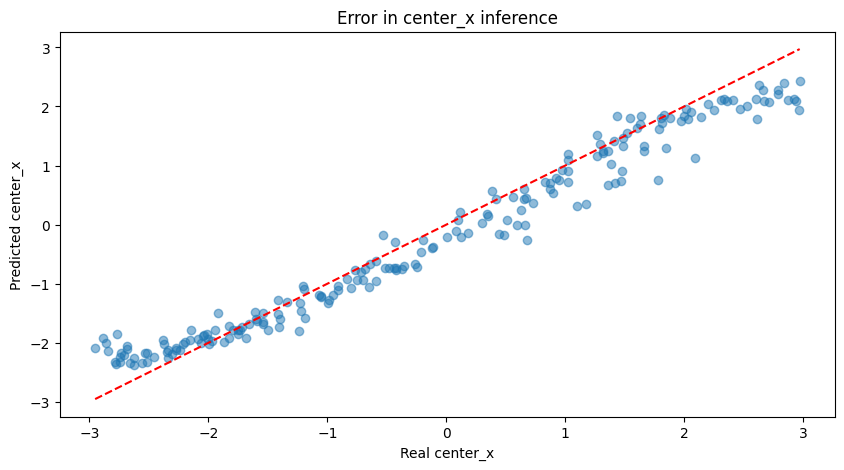

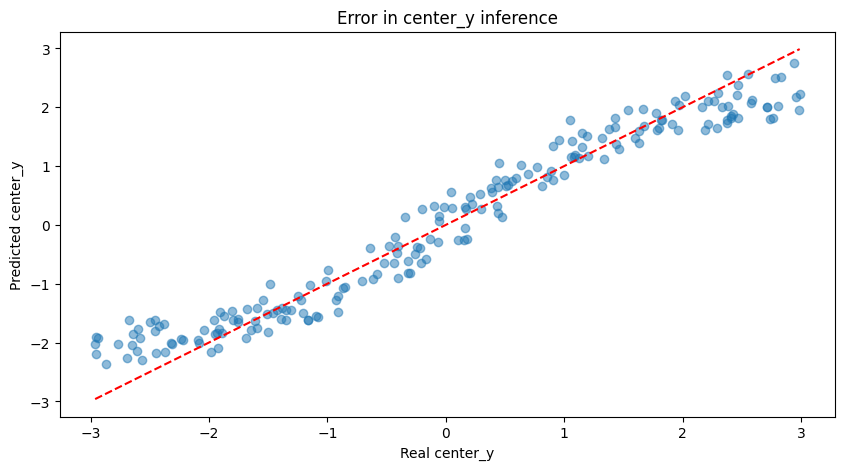

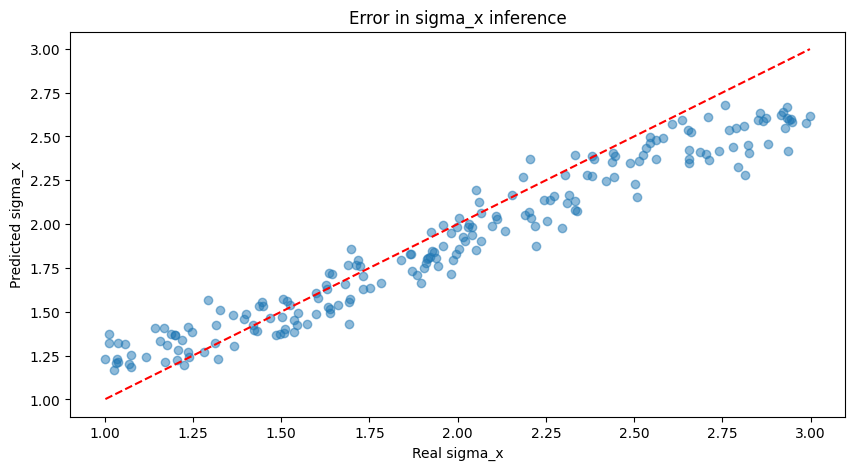

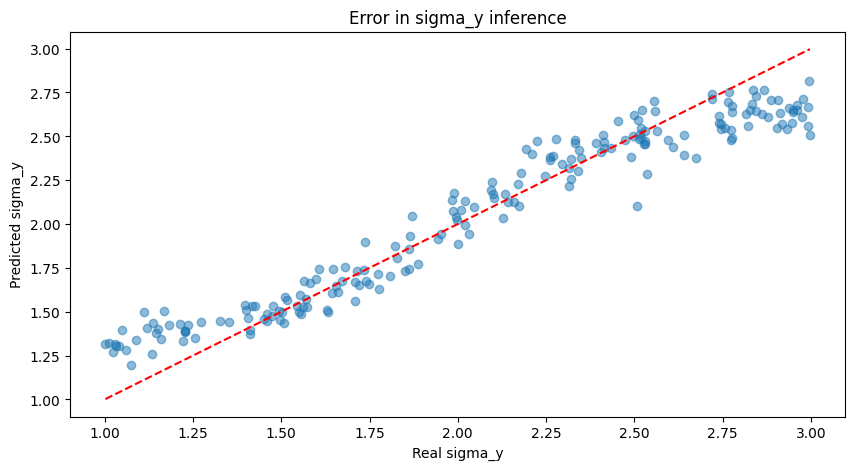

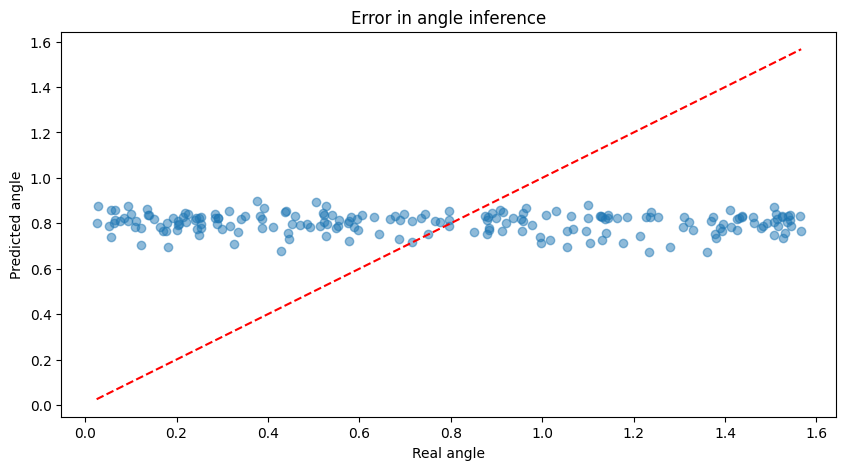

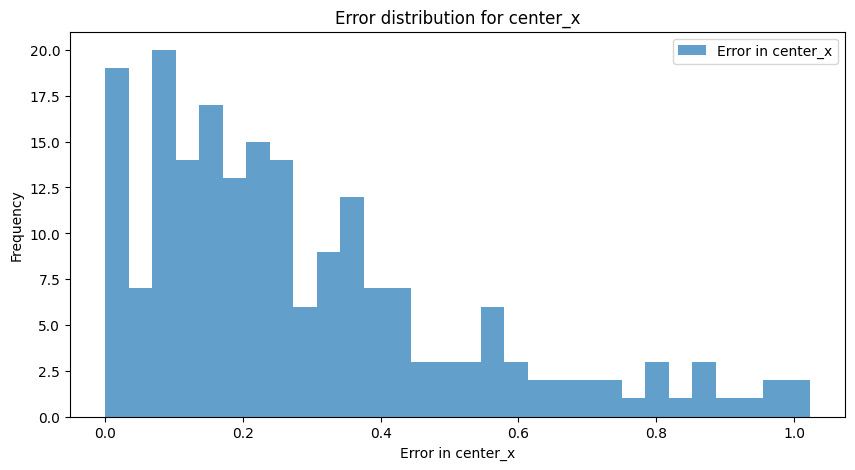

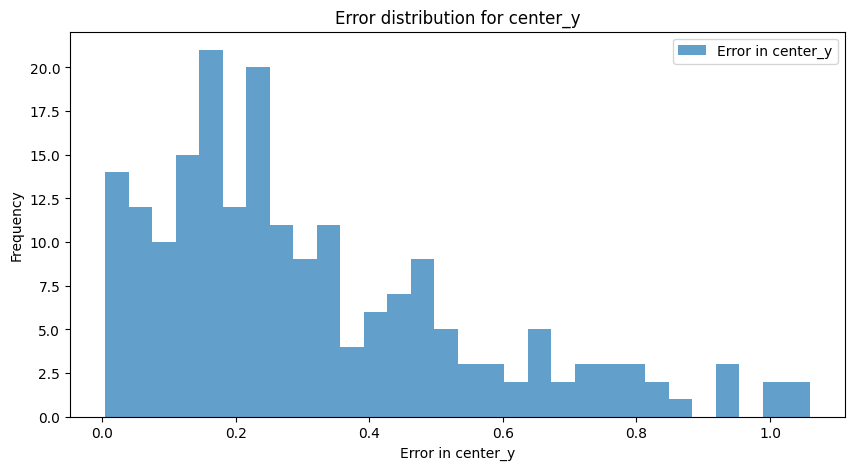

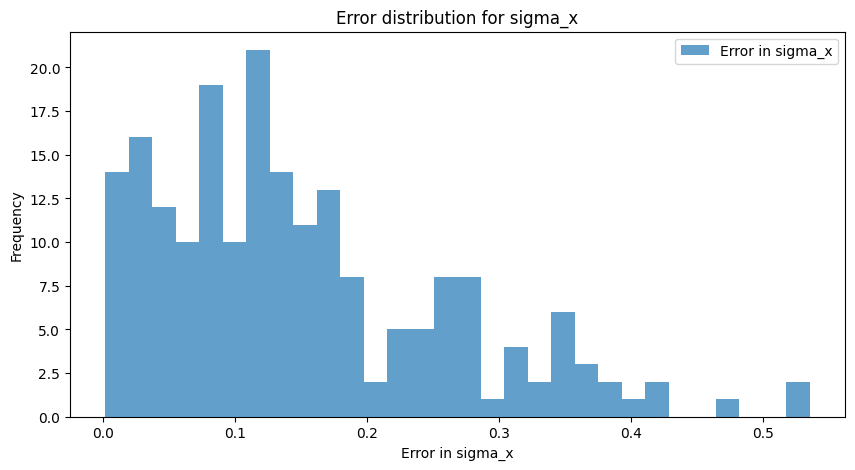

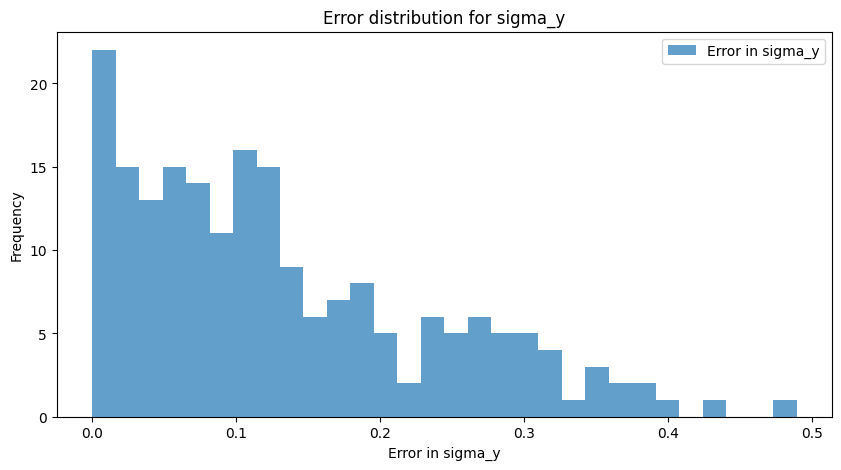

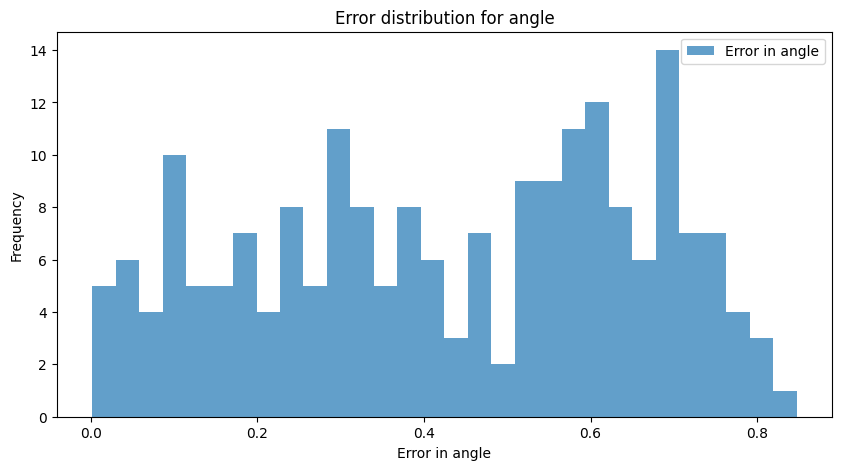

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split

# Cargar el archivo .npz
data = np.load('eval_intensity_matrices_with_params.npz')

# Extraer las matrices de intensidad y los parámetros
intensity_matrices = data['intensity_matrices']
parameters = data['parameters']

# Normalizar las imágenes
intensity_matrices = intensity_matrices / np.max(intensity_matrices)

# Normalizar los parámetros
parameters[:, 0] = (parameters[:, 0] + 3) / 6  # center_x normalizado entre 0 y 1
parameters[:, 1] = (parameters[:, 1] + 3) / 6  # center_y normalizado entre 0 y 1
parameters[:, 2] = (parameters[:, 2] - 1) / 2  # sigma_x normalizado entre 0 y 1
parameters[:, 3] = (parameters[:, 3] - 1) / 2  # sigma_y normalizado entre 0 y 1
parameters[:, 4] = (parameters[:, 4]) / (np.pi/2)  # angle normalizado entre 0 y 1

# Dividir el conjunto de datos en entrenamiento y validación
_, X_val, _, y_val = train_test_split(intensity_matrices, parameters, test_size=0.2, random_state=42)

# Expandir las dimensiones de las imágenes para que sean compatibles con la entrada de la CNN
X_val = np.expand_dims(X_val, axis=-1)

# Cargar el modelo entrenado
model = tf.keras.models.load_model('cnn_model.h5')

# Evaluar el modelo en el conjunto de validación
predictions = model.predict(X_val)

# Desnormalizar las predicciones y los valores reales
predictions[:, 0] = predictions[:, 0] * 6 - 3  # Desnormalizar center_x
predictions[:, 1] = predictions[:, 1] * 6 - 3  # Desnormalizar center_y
predictions[:, 2] = predictions[:, 2] * 2 + 1  # Desnormalizar sigma_x
predictions[:, 3] = predictions[:, 3] * 2 + 1  # Desnormalizar sigma_y
predictions[:, 4] = predictions[:, 4] * (np.pi/2)  # Desnormalizar angle

y_val[:, 0] = y_val[:, 0] * 6 - 3  # Desnormalizar center_x
y_val[:, 1] = y_val[:, 1] * 6 - 3  # Desnormalizar center_y
y_val[:, 2] = y_val[:, 2] * 2 + 1  # Desnormalizar sigma_x
y_val[:, 3] = y_val[:, 3] * 2 + 1  # Desnormalizar sigma_y
y_val[:, 4] = y_val[:, 4] * (np.pi/2)  # Desnormalizar angle

# Calcular el error absoluto medio para cada parámetro
mae_center_x = mean_absolute_error(y_val[:, 0], predictions[:, 0])
mae_center_y = mean_absolute_error(y_val[:, 1], predictions[:, 1])
mae_sigma_x = mean_absolute_error(y_val[:, 2], predictions[:, 2])
mae_sigma_y = mean_absolute_error(y_val[:, 3], predictions[:, 3])
mae_angle = mean_absolute_error(y_val[:, 4], predictions[:, 4])

print(f'MAE for center_x: {mae_center_x:.2f}')
print(f'MAE for center_y: {mae_center_y:.2f}')
print(f'MAE for sigma_x: {mae_sigma_x:.2f}')
print(f'MAE for sigma_y: {mae_sigma_y:.2f}')
print(f'MAE for angle: {mae_angle:.2f}')

# Graficar los errores de inferencia para cada parámetro
parameters = ['center_x', 'center_y', 'sigma_x', 'sigma_y', 'angle']
for i, param in enumerate(parameters):
    plt.figure(figsize=(10, 5))
    plt.scatter(y_val[:, i], predictions[:, i], alpha=0.5)
    plt.plot([y_val[:, i].min(), y_val[:, i].max()], [y_val[:, i].min(), y_val[:, i].max()], 'r--')
    plt.xlabel(f'Real {param}')
    plt.ylabel(f'Predicted {param}')
    plt.title(f'Error in {param} inference')
    plt.show()

# Graficar el error absoluto para cada parámetro
for i, param in enumerate(parameters):
    errors = np.abs(y_val[:, i] - predictions[:, i])
    plt.figure(figsize=(10, 5))
    plt.hist(errors, bins=30, alpha=0.7, label=f'Error in {param}')
    plt.xlabel(f'Error in {param}')
    plt.ylabel('Frequency')
    plt.title(f'Error distribution for {param}')
    plt.legend()
    plt.show()


Conclusión ha funcionado bastante bien, a excepción de la elipticidad. Dado que la elipticidad se genera a partir de un número aleatorio que será una perturbación en forma de "fase de sinusoide" que se añade a la ecuación de la gaussiana. Ésta no se puede predecir por ser aleatoria en un rango, si se guardara el valor resultante en lugar de el rango de aleatoriedad, sí que se podría inferir